In [13]:
#step 3


In [14]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt

import csv
import os

from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [15]:
!ls

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'Data_model_without_ clauses_including_adverbs.ipynb'
 data_without_clauses_including_adverbs.csv
 model_RuBert_base.ipynb
 test_orginal.csv
 test_without_clauses_including_adverbs.csv
 train_without_clauses_including_adverbs.csv


In [16]:
# Cargar los conjuntos de datos
train_df = pd.read_csv('train_without_clauses_including_adverbs.csv')
test_df = pd.read_csv('test_orginal.csv')


In [17]:
texts = train_df['text'].tolist()  # Convert to lists
labels = train_df['label'].tolist()
test_texts = test_df['text'].tolist()


In [18]:
model_name = "../ofline_models/ruBert-base"
# 1. Load Model and Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2) # num_classes: number of your classes



# 3. Tokenize and Create Input Tensors
max_length = 512  # Limitar la longitud máxima

encoded_data = tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors='pt')
input_ids = encoded_data['input_ids']
attention_mask = encoded_data['attention_mask']
labels_tensor = torch.tensor(labels)

#test part
encoded_test_data = tokenizer(test_texts, padding=True, truncation=True, max_length=max_length, return_tensors='pt')
test_input_ids = encoded_test_data['input_ids']
test_attention_mask = encoded_test_data['attention_mask']
test_labels_tensor = torch.tensor(test_df['label'].tolist())  # Si tienes etiquetas en el test set


# 4. Split Data into Training and Validation Sets
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, labels_tensor, test_size=0.2, random_state=42)
train_masks, val_masks, _, _ = train_test_split(attention_mask, input_ids, test_size=0.2, random_state=42)



# 5. Set up Optimizer
learning_rate = 1e-5 #1e-5, 2e-5, 3e-5, 5e-5.
optimizer = AdamW(model.parameters(), lr=learning_rate)  # Adjust learning rate

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ../ofline_models/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/workspace/notebooks/Carlos/fine_tunig_project/mi_entorno/lib/python3.8/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [19]:
# 6. Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # Move the model to the device
batch_size = 64  # Adjust batch size
num_epochs = 6  # Adjust the number of epochs


train_inputs = train_inputs.to(device)
train_labels = train_labels.to(device)
train_masks = train_masks.to(device)

val_inputs = val_inputs.to(device)
val_labels = val_labels.to(device)
val_masks = val_masks.to(device)



train_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1_scores = []
learning_rates = []  # Lista para guardar el learning rate

# Define the file path
csv_file_path = 'training_metrics_ruBert-base.csv'

# Verifica si el archivo existe y si no, agrega la cabecera
file_exists = os.path.isfile(csv_file_path)
with open(csv_file_path, mode='a', newline='') as file:  # Open ONCE before the loop
    writer = csv.writer(file)

    if not file_exists:  # Write header ONLY if the file doesn't exist
        writer.writerow(['Epoch', 'Train Loss', 'Validation Accuracy', 'Precision', 'Recall', 'F1 Score', 'Learning Rate'])


    # Ciclo de entrenamiento
    for epoch in range(num_epochs):
        # Actualiza el learning rate si es necesario (ejemplo de ajuste)
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)

        model.train()
        epoch_train_loss = 0
        for i in range(0, len(train_inputs), batch_size):
            batch_inputs = train_inputs[i:i+batch_size].to(device)
            batch_labels = train_labels[i:i+batch_size].to(device)
            batch_masks = train_masks[i:i+batch_size].to(device)

            outputs = model(batch_inputs, attention_mask=batch_masks, labels=batch_labels)
            loss = outputs.loss 
            optimizer.zero_grad()

            loss.backward()
            epoch_train_loss += loss.item()
            optimizer.step()

        # Promedio de la pérdida en el entrenamiento para esta época
        avg_train_loss = epoch_train_loss / len(train_inputs)
        train_losses.append(avg_train_loss)

        # 7. Validación
        model.eval()
        val_preds = []
        val_true = []
        with torch.no_grad():
            for i in range(0, len(val_inputs), batch_size):
                batch_inputs = val_inputs[i:i+batch_size].to(device)
                batch_labels = val_labels[i:i+batch_size].to(device)
                batch_masks = val_masks[i:i+batch_size].to(device)

                outputs = model(batch_inputs, attention_mask=batch_masks)
                logits = outputs.logits
                preds = torch.argmax(logits, dim=-1)
                val_preds.extend(preds.cpu().numpy())
                val_true.extend(batch_labels.cpu().numpy())

        val_accuracy = accuracy_score(val_true, val_preds)
        val_precision = precision_score(val_true, val_preds, average='weighted')
        val_recall = recall_score(val_true, val_preds, average='weighted')
        val_f1 = f1_score(val_true, val_preds, average='weighted')

        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1_scores.append(val_f1)

        print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, "
              f"Validation Accuracy: {val_accuracy:.4f}, "
              f"Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")
        writer.writerow([epoch+1, avg_train_loss, val_accuracy, val_precision, val_recall, val_f1, current_lr])


    # Al finalizar, las métricas se habrán guardado en 'training_metrics.csv'
    # Evaluación final en el conjunto de test
model.eval()
test_preds = []
test_true = []
with torch.no_grad():
    for i in range(0, len(test_input_ids), batch_size):
        batch_inputs = test_input_ids[i:i + batch_size].to(device)
        batch_labels = test_labels_tensor[i:i + batch_size].to(device)
        batch_masks = test_attention_mask[i:i + batch_size].to(device)

        outputs = model(batch_inputs, attention_mask=batch_masks)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        test_preds.extend(preds.cpu().numpy())
        test_true.extend(batch_labels.cpu().numpy())

    # Calcular las métricas para el conjunto de test
test_accuracy = accuracy_score(test_true, test_preds)
test_precision = precision_score(test_true, test_preds, average='weighted')
test_recall = recall_score(test_true, test_preds, average='weighted')
test_f1 = f1_score(test_true, test_preds, average='weighted')

print(f"Test Accuracy: {test_accuracy:.4f}, "
      f"Test Precision: {test_precision:.4f}, "
      f"Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}")
with open(csv_file_path, mode='a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Test", "", test_accuracy, test_precision, test_recall, test_f1, ""])


Epoch 1: Train Loss: 0.0096, Validation Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Epoch 2: Train Loss: 0.0036, Validation Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Epoch 3: Train Loss: 0.0017, Validation Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Epoch 4: Train Loss: 0.0010, Validation Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Epoch 5: Train Loss: 0.0007, Validation Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Epoch 6: Train Loss: 0.0005, Validation Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Test Accuracy: 0.2475, Test Precision: 0.0613, Test Recall: 0.2475, Test F1: 0.0982


/workspace/notebooks/Carlos/fine_tunig_project/mi_entorno/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


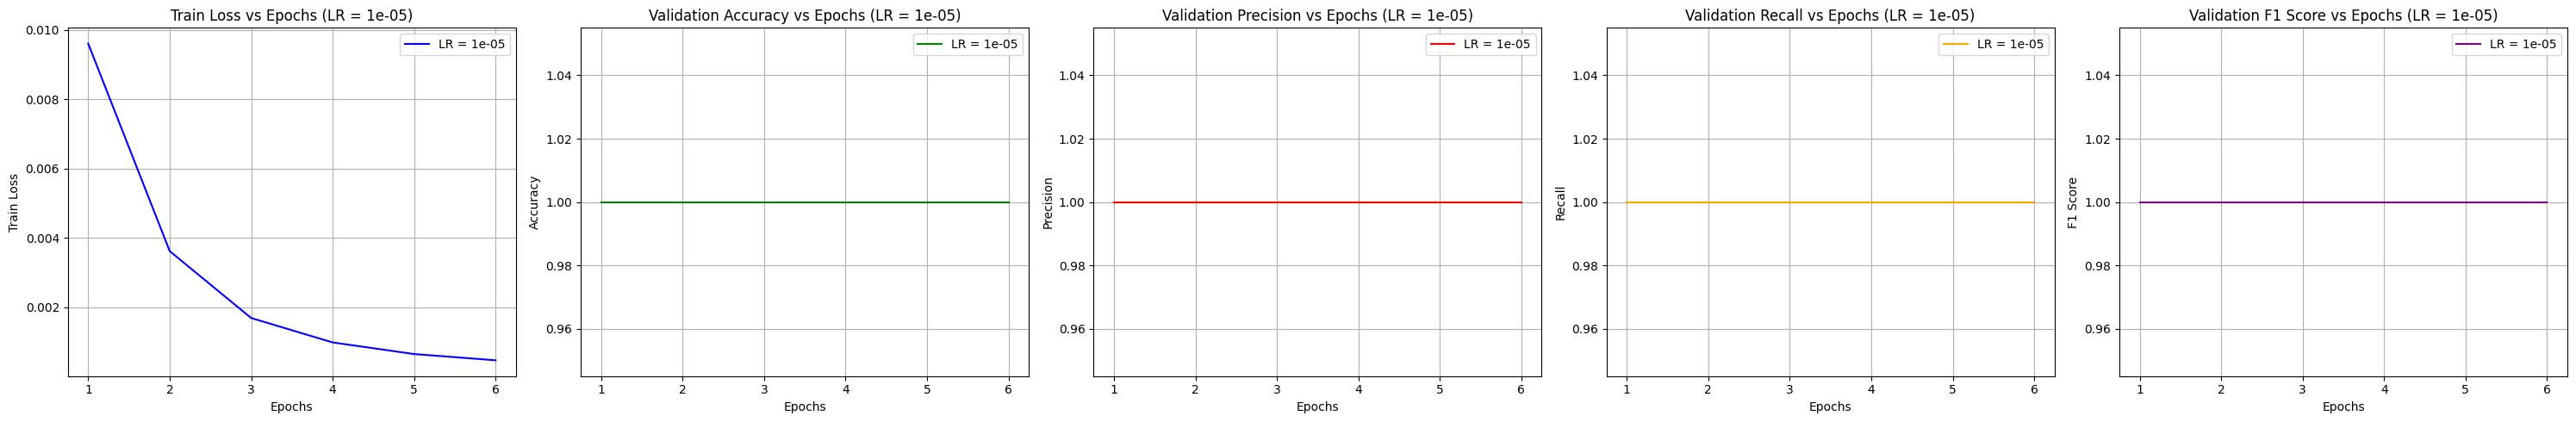

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Leer el archivo CSV
df = pd.read_csv('training_metrics_ruBert-base.csv')

# Eliminar las filas que contienen 'Test' en la columna 'Epoch'
df = df[df['Epoch'] != 'Test']

# Convertir las columnas relevantes a su tipo adecuado (numérico)
df['Epoch'] = pd.to_numeric(df['Epoch'])
df['Train Loss'] = pd.to_numeric(df['Train Loss'])
df['Validation Accuracy'] = pd.to_numeric(df['Validation Accuracy'])
df['Precision'] = pd.to_numeric(df['Precision'])
df['Recall'] = pd.to_numeric(df['Recall'])
df['F1 Score'] = pd.to_numeric(df['F1 Score'])
df['Learning Rate'] = pd.to_numeric(df['Learning Rate'])

# Obtener los valores únicos de learning rate
learning_rates = df['Learning Rate'].unique()

# Crear la figura y los ejes
num_rows = len(learning_rates)
num_cols = 5  # Número de columnas (gráficos por LR)
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(30, 5 * num_rows))

# Verificar si solo hay una fila para evitar errores de dimensiones
if num_rows == 1:
    axes = axes.reshape(1, num_cols)  # Redimensionar a 2D si solo hay una fila

# Iterar sobre cada valor de learning rate
for i, lr in enumerate(learning_rates):
    # Filtrar los datos para este learning rate
    lr_data = df[df['Learning Rate'] == lr]

    # Entrenamiento vs Pérdida
    axes[i, 0].plot(lr_data['Epoch'], lr_data['Train Loss'], label=f'LR = {lr}', color='blue')
    axes[i, 0].set_title(f'Train Loss vs Epochs (LR = {lr})')
    axes[i, 0].set_xlabel('Epochs')
    axes[i, 0].set_ylabel('Train Loss')
    axes[i, 0].grid(True)
    axes[i, 0].legend()  # Añadir leyenda

    # Precisión de validación
    axes[i, 1].plot(lr_data['Epoch'], lr_data['Validation Accuracy'], label=f'LR = {lr}', color='green')
    axes[i, 1].set_title(f'Validation Accuracy vs Epochs (LR = {lr})')
    axes[i, 1].set_xlabel('Epochs')
    axes[i, 1].set_ylabel('Accuracy')
    axes[i, 1].grid(True)
    axes[i, 1].legend()

    # Precisión de validación
    axes[i, 2].plot(lr_data['Epoch'], lr_data['Precision'], label=f'LR = {lr}', color='red')
    axes[i, 2].set_title(f'Validation Precision vs Epochs (LR = {lr})')
    axes[i, 2].set_xlabel('Epochs')
    axes[i, 2].set_ylabel('Precision')
    axes[i, 2].grid(True)
    axes[i, 2].legend()

    # Recall de validación
    axes[i, 3].plot(lr_data['Epoch'], lr_data['Recall'], label=f'LR = {lr}', color='orange')
    axes[i, 3].set_title(f'Validation Recall vs Epochs (LR = {lr})')
    axes[i, 3].set_xlabel('Epochs')
    axes[i, 3].set_ylabel('Recall')
    axes[i, 3].grid(True)
    axes[i, 3].legend()

    # F1 Score de validación
    axes[i, 4].plot(lr_data['Epoch'], lr_data['F1 Score'], label=f'LR = {lr}', color='purple')
    axes[i, 4].set_title(f'Validation F1 Score vs Epochs (LR = {lr})')
    axes[i, 4].set_xlabel('Epochs')
    axes[i, 4].set_ylabel('F1 Score')
    axes[i, 4].grid(True)
    axes[i, 4].legend()

# Ajustar el espaciado de los subgráficos
plt.tight_layout()

# Mostrar los gráficos
plt.show()
